In [40]:
import astropy
import astropy.units as u
import astroquery
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.time import Time 
import os
from astropy.io.votable import parse_single_table
from astropy.time import Time
import pytest
from astropy.table import Table, vstack
import csv
import pandas as pd
from astropy.io.votable import from_table, writeto
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames

In [2]:
def psr_to_gaia_nominal(jname, raj, decj, radius):
    """
        looks for Gaia matches to a single pulsar within a specified radius, and returns the table resulting 
        from the Gaia query with the psr name, ra and dec
    """
    
    # Query Gaia within the range of the given pulsar 
    Gaia.ROW_LIMIT = 2000
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3
    sc = SkyCoord(ra= raj, dec= decj, frame= 'icrs', unit=(u.hourangle, u.deg))
    j = Gaia.cone_search_async(coordinate=sc, radius=u.Quantity(radius, u.arcsec))
    results = j.get_results()

    # use python sort function
    
    if len(results) == 0:
        return results
    else:
        results.add_column(jname, name='Companion Pulsar', index=0)
        results.add_column(raj, name='Pulsar RA', index=1)
        results.add_column(decj, name='Pulsar DEC', index=2)
        return results


In [3]:
def psr_to_gaia(jname, raj, decj,  pmra, pmdec, posepoch, radius):
    """Searches Gaia for possible companion to any given pulsar

    Given input parameters read in from a text file following the guidelines of ATNF parameters, 
    queries Gaia DR2 to find matches (nearby objects from Gaia) based on RA and Dec for each object 
    from the text file to within a certain range, the default being 1 arcmin in both ra and dec.

    Args:
        jname (str): Name of the pulsar being checked for matches 
        raj (str): Right ascension of the pulsar in hh:mm:ss.ss format -- is this actually what it is?
        decj (str): Declination of the pulsar in degrees:mm:ss.ss format -- is this actually what it is?
        pmra (str): Proper motion in ra of the pulsar in string format and mas/yr units
        pmdec (str): proper motion in dec of the pulsar in string format and mas/yr units
        posepoch (str): epoch that the data was taken in string format and mjd units
        height (float): Height of Gaia box search in arcminutes
        width (float): Width of Gaia box search in arcminutes 
        radius (float): Radius of the Gaia cone search in arcminutes
    
    Returns:
        Table: results of the Gaia query in an astropy Table  
    """

    from astropy.time import Time 
    ra = Angle(raj, unit = u.hourangle) # comes in as a string of units hh:mm:ss.ss
    dec = Angle(decj, unit = u.deg) # comes in as a string of units dd:mm:ss.s
    p_pmra = u.Quantity(pmra, u.mas/u.yr) # comes in as a string of units mas/yr
    p_pmdec = u.Quantity(pmdec, u.mas/u.yr) # comes in as a string of units mas/yr
    p_epoch = Time(posepoch, format='mjd').jyear # comes in in units mjd, is immediately converted to jyear tcb

    psr = SkyCoord(ra= raj, dec= decj, unit= (u.hourangle, u.deg), frame = 'icrs', pm_ra_cosdec= p_pmra, pm_dec= p_pmdec)

    # to propogate location of pulsar up to gaia time, must calculate epoch difference
    gaia_epoch = Time('2016.0', format='jyear').jyear
    year_diff = (gaia_epoch.tolist() * u.yr) - (p_epoch.tolist() * u.yr) # difference b/w epochs in years

    # define our new vector of pm times the time diff
    pmtransra = psr.pm_ra_cosdec * year_diff
    pmtransdec = psr.pm_dec * year_diff

    ra_dr3 = psr.ra.to_value(u.mas) * u.mas + (pmtransra)
    dec_dr3 = psr.dec.to_value(u.mas) * u.mas + (pmtransdec)

    # define a new SkyCoord object with the propagated positions
    psr_dr3 = SkyCoord(ra= ra_dr3, dec= dec_dr3, unit= (u.mas, u.mas), frame= 'icrs', pm_ra_cosdec= p_pmra, pm_dec= p_pmdec)

    # Query Gaia within the range of the given pulsar 
    Gaia.ROW_LIMIT = 2000
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3
    #coord=SkyCoord(ra=p_new_ra, dec=p_new_dec, unit=(u.degree, u.degree), frame='icrs')
    j = Gaia.cone_search_async(coordinate=psr_dr3, radius=u.Quantity(radius, u.arcsec))
    results = j.get_results()

    # use python sort function
    
    if len(results) == 0:
        with open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'a') as fd:
            fd.write(jname + ',\n')
            fd.close()
        return results
    else:
        results.add_column(jname, name='Companion Pulsar', index=0)
        results.add_column(raj, name='Pulsar RA', index=1)
        results.add_column(decj, name='Pulsar DEC', index=2)
        results.write('temp.csv', overwrite=True) #writes the results of a single query to a csv file
        f = open('temp.csv', 'r')
        for line in f:
            with open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'a') as fd:
                fd.write(line)
                fd.close()
        return results

In [4]:
def get_matches(input_file, radius=1.):
    """Takes a list of pulsars and returns a list of those with potential matches.

    Takes as input a text file (.csv file) with index number, name, ra, dec, proper
    motion ra, proper motion dec and posepoch of a list of pulsars and produces all of the gaia 
    matches of ra and dec to within a certain range.

    Args: 
        input_file (str): Name of the text file (csv) containing each pulsar with the parameters 'index', 'jname', 
            'ra', 'dec', 'pmra', 'pmdec', 'posepoch' row by row for each object.
        output_file (str): Name of the text file which the pulsar-gaia matches will be output to. If desired,
            specify the full path to which the file should be saved, otherwise it will just be saved to the 
            present working directory
        height (:obj:'float', optional): Height of the rectangle Gaia will query in.
        width (:obj:'float', optional): Width of the rectangle Gaia will query in.
        radius (:obj:'float', optional): Radius of the circle Gaia will query in. 


    """
    from astropy.table import Table, vstack

    f = open(input_file, "r")
    results = Table()
    first_time = True
    skipped = 0

    # Loop through file of ATNF data and combine tables of Gaia matches into one supertable
    for line in f:

      # Parse input
      values = line.split(';')

      if values[3] == '*' or values[4] == '*' or values[6] == '*' or values[7] == '*' or values[9] == '*' or values[10] == '*' or values[12] == '*' or values[13] == '*' or values[15] == '*':
        skipped += 1
        with open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'a') as fd:
          fd.write(values[1] + ',\n')
          fd.close()
        continue

      # write a condition that will perform the query if that pulsar is not in the table, and will skip if it is
      query = True
      g = open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'r')
      for line in g:
        name = line.split(',')
        if name[0] == values[1]:
          query = False
          break
      
      if query:
        # Add result to supertable
        #psr_to_gaia(jname, raj, decj,  pmra, pmdec, posepoch, radius)
        search_result = psr_to_gaia(values[1],values[3],values[6],values[9],values[12],values[15],radius)
        if (len(search_result) == 0):
          continue
        if first_time:
          results = search_result
          first_time = False
        else:  
          results = vstack([results, search_result])

    hits = len(results)
    # results.write(output_file, format='csv', overwrite=True)
    return results, hits, skipped

In [50]:
# first step is to run get matches for 10 arcsec
filetouse = '/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/atnf_csv_w_errors.csv'
table, hits, skipped = get_matches(filetouse, radius= 10.)

In [5]:
#initialize the tables that will end up becoming the columns of our astropy table:
psr = []
psr_ra = []
psr_dec = []
ra = []
dec = []
hits = 0
psrs_hits = 0
skipped = 0
first = True
# document containing all of the pulsars in the ATNF catalogue, and their matches out the 10 "
h = open('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'r') 
# the for loop below takes our csv containg the pulsar information and creates an astropy table with all the hits
for line in h:
    values = line.split(',') # parse through csv, one Gaia source corresponding to some pulsar per line
    if len(values) < 3: 
        skipped += 1 # skips pulsars that don't have any matches
    else:
        if values[0] == 'Companion Pulsar':
            psrs_hits += 1
            continue # skips lines that are just metadata-ish
        else:
            hits += 1
            if first:
                first = False
                psr.insert(0, values[0])
                psr_ra.insert(0, values[1])
                psr_dec.insert(0, values[2])
                ra.insert(0, values[8])
                dec.insert(0, values[10])
            else:
                psr.append(values[0])
                psr_ra.append(values[1])
                psr_dec.append(values[2])
                ra.append(values[8])
                dec.append(values[10])

# instantiate the astropy table to be created
table = Table([psr, psr_ra, psr_dec, ra, dec], names= ['Pulsar', 'Pulsar RA', 'Pulsar DEC', 'ra', 'dec'])

In [ ]:
# save this table to a .npz file 
np.savez('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec', Pulsar = table['Pulsar'], 
        Pulsar_RA = table['Pulsar RA'], Pulsar_DEC = table['Pulsar DEC'], ra = table['ra'], dec = table['dec'])

np.savez('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec_astropy', table = table)

In [6]:
# here we are creating a list of the names of the pulsars that had hits, without reduplication
current = 'J0024-7204aa'
psrs_with_hits = [current]
for b in table['Pulsar']:
    if b != current:
        psrs_with_hits.append(b)
        current = b
len(psrs_with_hits) # total number of PULSARS with hits, distinct from total number of hits

437

In [7]:
# create a SkyCoord object for each pulsar in the astropy table
psr_pos = SkyCoord(table['Pulsar RA'], table['Pulsar DEC'], frame = 'icrs', unit =(u.hourangle, u.deg))
# create a SkyCoord object for each Gaia source in the astropy table
source_pos = SkyCoord(table['ra'], table['dec'], frame = 'icrs', unit= (u.deg, u.deg))

source_seps = []
first_time = True
# this for loop will create a table of the sky separations fo each pulsar and Gaia source pair in the astropy table
for k in range(len(table)):
    if first_time:
        source_seps.insert(0,psr_pos[k].separation(source_pos[k]))
        first_time = False
    else:
        source_seps.append(psr_pos[k].separation(source_pos[k]))

In [52]:
# here we are creating a list of the names of the pulsars that had hits, without reduplication
current = 'J0024-7204aa'
decs = [psr_pos[0].dec] # declination of the first pulsar in the table
ras = [psr_pos[0].ra] # ra of the first pulsar in the table
a = 0
for b in table['Pulsar']:
    if b != current:
        decs.append(psr_pos[a].dec)
        ras.append(psr_pos[a].ra)
        current = b
    a += 1
ras[0] # total number of PULSARS with hits, distinct from total number of hits

<Longitude 6.023625 deg>

In [9]:
# table with the minimum distance to at least 1 hit for every pulsar in psrs_with_hits
mins = np.zeros(len(psrs_with_hits))
for d in range(len(psrs_with_hits)):
    first_time = True
    for c in range(len(table['Pulsar'])):
        # for each pulsar, go through all the Gaia sources associated with that psr, and place the one with minimal separation in mins
        if table['Pulsar'][c] == psrs_with_hits[d]:
            if first_time:
                first_time = False
                minimum = source_seps[c].to_value(u.arcsec)
            else:
                if source_seps[c].to_value(u.arcsec) < minimum:
                    minimum = source_seps[c].to_value(u.arcsec)
    mins[d] = minimum

In [53]:
# create an astropy table that contains each unique pulsar with a hit, and the minimal distance to a Gaia source for each psr
min_dist = Table([psrs_with_hits, mins, decs, ras], names= ['Pulsars with Hits', 'Distance to at least 1 hit', 'Declinations', 'Right Ascensions'])
#min_dist['Declinations']

# create a restricted table of just pulsars within 10 deg declination of the galactic plane:
restrictions = [5, 10]
rest_psrs_with_hits = []
rest_mins = []
rest_decs = []
rest_ras = []
first_time = True
for a in range(len(restrictions)):
    for i in range(len(min_dist['Pulsars with Hits'])):
        if min_dist['Declinations'][i] > -28.94 - restrictions[a] and min_dist['Declinations'][i] < -28.94 + restrictions[a]:
            if first_time:
                rest_psrs_with_hits.insert(0, min_dist['Pulsars with Hits'][i])
                rest_mins.insert(0, min_dist['Distance to at least 1 hit'][i])
                rest_decs.insert(0, min_dist['Declinations'][i])
                rest_ras.insert(0, min_dist['Right Ascensions'][i])
                first_time = False
            else:
                rest_psrs_with_hits.append(min_dist['Pulsars with Hits'][i])
                rest_mins.append(min_dist['Distance to at least 1 hit'][i])
                rest_decs.append(min_dist['Declinations'][i]) 
                rest_ras.append(min_dist['Right Ascensions'][i])
    if a == 0:
        rest_min_dist5 = Table([rest_psrs_with_hits, rest_mins, rest_decs, rest_ras], names= ['Pulsars with Hits', 'Distance to at least 1 hit', 'Declinations', 'Right Ascensions'])
    else:
        rest_min_dist10 = Table([rest_psrs_with_hits, rest_mins, rest_decs, rest_ras], names= ['Pulsars with Hits', 'Distance to at least 1 hit', 'Declinations', 'Right Ascensions'])

In [116]:
# now, looking at abs(b) < 5, look at both inner galaxy and outer galaxy
# in galactic coordinates, do l = -90 to 90 deg for inner galaxy (galactic center is l = 0 degrees)
# in ra, l = 0 corresponds to ra = 17h45.6m

ub = SkyCoord(l=90, b=0, frame='galactic', unit= u.deg)
lb = SkyCoord(l=-90, b=0, frame='galactic', unit= u.deg)
gal_center = SkyCoord(l=0,b=0, frame='galactic', unit= u.deg)

# inner galaxy
# take the pulsars in rest_min_dist5, the table with all the pulsars with hits within 5 deg of the galactic plane, and restrict to those between lr and ur
upper_rest = ub.icrs.ra
lower_rest = lb.icrs.ra
inner_gal = rest_min_dist5[:0].copy()
for i in range(len(rest_min_dist5)):
    if rest_min_dist5['Right Ascensions'][i] < upper_rest.value and rest_min_dist5['Right Ascensions'][i] > lower_rest.value:
        inner_gal.add_row(rest_min_dist5[i])
np.savez('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec_innergal', table = inner_gal)

# outer galaxy
# take the pulsars in rest_min_dist5, the table with all the pulsars with hits within 5 deg of the galactic plane, and restrict to those between lr and ur on the other side
outer_gal = rest_min_dist5[:0].copy()
for j in range(len(rest_min_dist5)):
    if rest_min_dist5['Right Ascensions'][j] > upper_rest.value or rest_min_dist5['Right Ascensions'][j] < lower_rest.value:
        outer_gal.add_row(rest_min_dist5[j])
np.savez('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec_outergal', table = outer_gal)

inner_gal

Pulsars with Hits,Distance to at least 1 hit,Declinations,Right Ascensions
str12,float64,float64,float64
J1600-3053,8.76925163913067,-30.89705349722222,240.21626292499997
J1623-2631,1.696396589692342,-26.531602499999998,245.90925749999997
J1701-3006A,0.5836020603774617,-30.10838138888889,255.30212258333327
J1701-3006B,0.9118414592998106,-30.113623333333337,255.30278208333328
J1701-3006C,0.7632169846298064,-30.11650416666667,255.30360799999997
J1701-3006D,0.8974410117606866,-30.111821944444447,255.30651291666663
J1701-3006E,0.48409417546269007,-30.113025,255.3053058333333
J1701-3006F,0.4405060820972101,-30.114394444444446,255.3034258333333
J1701-3006G,0.6029222006589021,-30.111666666666668,255.30833333333328


Text(0.5, 0.01, 'Distance to at least 1 Gaia source (")')

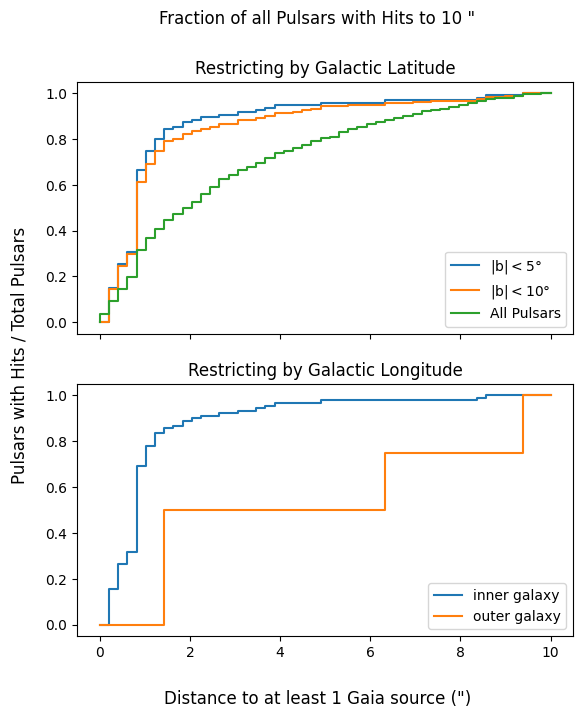

In [114]:
dist_to_one_psr = np.linspace(0,10,50) # x-axis: possible psr-Gaia separations
n_psr_norm5 = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(rest_min_dist5['Distance to at least 1 hit'])):
        if rest_min_dist5['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm5[e] = num/len(rest_min_dist5['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits
n_psr_norm5

n_psr_norm10 = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(rest_min_dist10['Distance to at least 1 hit'])):
        if rest_min_dist10['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm10[e] = num/len(rest_min_dist10['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits
n_psr_norm10

n_psr_norm = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(min_dist['Distance to at least 1 hit'])):
        if min_dist['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm[e] = num/len(min_dist['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits
n_psr_norm

n_psr_norm_inner = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(inner_gal['Distance to at least 1 hit'])):
        if inner_gal['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm_inner[e] = num/len(inner_gal['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits

n_psr_norm_outer = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(outer_gal['Distance to at least 1 hit'])):
        if outer_gal['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm_outer[e] = num/len(outer_gal['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits

# plot values
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize= (6.4, 7.2))
ax1.step(dist_to_one_psr, n_psr_norm5, label= r'|b|$ < 5 \degree$')
ax1.step(dist_to_one_psr, n_psr_norm10, label= r'|b|$ < 10 \degree$')
ax1.step(dist_to_one_psr, n_psr_norm, label= 'All Pulsars')
# ax1.set_xlabel('Distance to at least 1 Gaia source (")')
# ax1.set_ylabel('Pulsars with Hits / Total Pulsars')
ax1.set_title('Restricting by Galactic Latitude')
ax1.legend()

ax2.step(dist_to_one_psr, n_psr_norm_inner, label= 'inner galaxy')
ax2.step(dist_to_one_psr, n_psr_norm_outer, label= 'outer galaxy')
# ax2.set_xlabel('Distance to at least 1 Gaia source (")')
# ax2.set_ylabel('Pulsars with Hits / Total Pulsars')
ax2.set_title('Restricting by Galactic Longitude')
ax2.legend()

fig.suptitle('Fraction of all Pulsars with Hits to 10 "')
fig.supylabel('Pulsars with Hits / Total Pulsars')
fig.supxlabel('Distance to at least 1 Gaia source (")')

In [23]:
seps1 = np.linspace(0,10,200)
seps2 = np.linspace(0, 4, 25)

numhits1 = np.zeros(len(seps1)) 
for i in range(len(seps1)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps1[i]:
            num += 1
    numhits1[i] = num

numhits2 = np.zeros(len(seps2)) 
for i in range(len(seps2)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps2[i]:
            num += 1
    numhits2[i] = num

numhits2

array([   0.,   16.,   32.,   52.,   73.,  139.,  165.,  211.,  284.,
        403.,  453.,  560.,  667.,  739.,  806.,  886., 1067., 1211.,
       1300., 1472., 1607., 1812., 2033., 2165., 2393.])

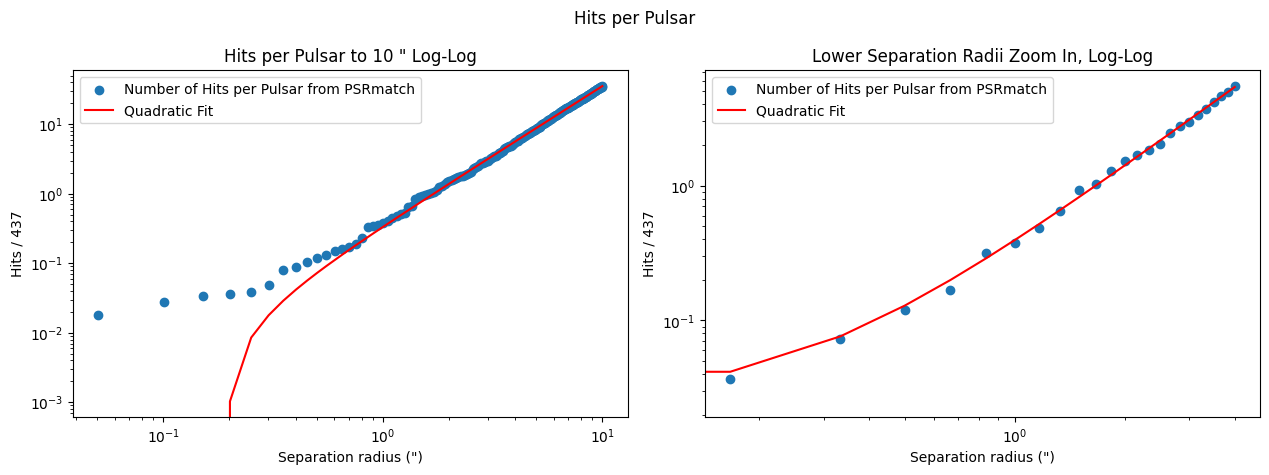

In [25]:
hits_per_pulsar1 = numhits1/(psrs_hits)
hits_per_pulsar2 = numhits2/(psrs_hits)
a1, b1, c1 = np.polyfit(seps1, hits_per_pulsar1, 2)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(12.8, 4.8))
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122)
# ax3 = plt.subplot(121)
# ax4 = plt.subplot(122)
ax5 = plt.subplot(121)
ax6 = plt.subplot(122)

# # log linear
# ax1.set_yscale('log')
# ax1.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
# ax1.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax1.set_xlabel('Separation radius (")')
# ax1.set_ylabel('Hits / 437')
# ax1.set_title('Hits per Pulsar to 10 " Log-Linear')
# ax1.legend()

# ax2.set_yscale('log')
# ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
# ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax2.set_xlabel('Separation radius (")')
# ax2.set_ylabel('Hits / 437')
# ax2.set_title('Lower Separation Radii Zoom In, Log-Linear')
# ax2.legend()

# #linear 
# ax3.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
# ax3.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax3.set_xlabel('Separation radius (")')
# ax3.set_ylabel('Hits / 437')
# ax3.set_title('Hits per Pulsar to 10 " Linear')
# ax3.legend()

# ax4.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
# ax4.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax4.set_xlabel('Separation radius (")')
# ax4.set_ylabel('Hits / 437')
# ax4.set_title('Lower Separation Radii Zoom In, Linear')
# ax4.legend()

#log-log
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
ax5.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
ax5.set_xlabel('Separation radius (")')
ax5.set_ylabel('Hits / 437')
ax5.set_title('Hits per Pulsar to 10 " Log-Log')
ax5.legend()

ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax6.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
ax6.set_xlabel('Separation radius (")')
ax6.set_ylabel('Hits / 437')
ax6.set_title('Lower Separation Radii Zoom In, Log-Log')
ax6.legend()

fig.suptitle('Hits per Pulsar')
fig.tight_layout()

In [25]:
dist_to_one_psr = np.linspace(0,1,30)
n_psr = np.zeros(len(dist_to_one_psr))
for i in range(len(dist_to_one_psr)):
    first_one = True
    psrs = []
    for j in range(len(source_seps)):
        if source_seps[j].value < dist_to_one_psr[i]:
            if first_one:
                psrs.insert(0,table['Pulsar'][j])
                first_one = False
            else:
                add = True
                for k in range(len(psrs)):
                    if table['Pulsar'][j] == psrs[k]:
                        add = False
                if add:
                    psrs.append(table['Pulsar'][j])
    n_psr[i] = len(psrs)
n_psr

array([  0., 437., 437., 437., 437., 437., 437., 437., 437., 437., 437.,
       437., 437., 437., 437., 437., 437., 437., 437., 437., 437., 437.,
       437., 437., 437., 437., 437., 437., 437., 437.])

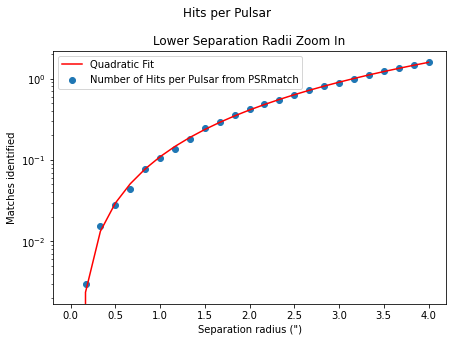

In [5]:
zoomed_hits_per_psr = np.array([   0.,   10.,   51.,   94.,  149.,  257.,  349.,  460.,  606.,
        823.,  986., 1198., 1409., 1618., 1830., 2110., 2432., 2714.,
       2969., 3273., 3646., 4080., 4497., 4833., 5314.])

seps2 = np.linspace(0, 4, 25)

hits_per_pulsar2 = zoomed_hits_per_psr/(3342)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(6.4, 4.8))
ax2 = plt.subplot()

ax2.set_yscale('log')
ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
ax2.set_xlabel('Separation radius (")')
ax2.set_ylabel('Matches identified')
ax2.set_title('Lower Separation Radii Zoom In')
ax2.legend()

fig.suptitle('Hits per Pulsar')
fig.tight_layout()